In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

set_seed()

In [2]:
from pathlib import Path
import requests

peptide_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/peptide.fasta'
receptor_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/receptor.fasta'
peptide_data = requests.get(peptide_url).text
receptor_data = requests.get(receptor_url).text
with open('peptide.fasta', 'w') as f:
  f.write(peptide_data)
with open('receptor.fasta', 'w') as f:
  f.write(receptor_data)

peptides, receptors = [], []
with open('receptor.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            receptors.append(line.replace('\n', ''))

with open('peptide.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            peptides.append(line.replace('\n', ''))
assert len(peptides) == len(receptors)

In [3]:
!wget https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
!tar xvzf mmseqs-linux-avx2.tar.gz
!cp mmseqs/bin/mmseqs /usr/bin/
!pip install biopython

--2023-10-27 05:33:12--  https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
Resolving mmseqs.com (mmseqs.com)... 147.46.145.74
Connecting to mmseqs.com (mmseqs.com)|147.46.145.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45098845 (43M) [application/octet-stream]
Saving to: ‘mmseqs-linux-avx2.tar.gz’

mmseqs-linux-avx2.t 100%[===================>]  43.01M  12.6MB/s    in 3.7s    

2023-10-27 05:33:16 (11.7 MB/s) - ‘mmseqs-linux-avx2.tar.gz’ saved [45098845/45098845]

mmseqs/
mmseqs/bin/
mmseqs/bin/mmseqs
mmseqs/matrices/
mmseqs/matrices/blosum90.out
mmseqs/matrices/blosum50.out
mmseqs/matrices/blosum75.out
mmseqs/matrices/PAM50.out
mmseqs/matrices/blosum45.out
mmseqs/matrices/VTML120.out
mmseqs/matrices/blosum65.out
mmseqs/matrices/PAM60.out
mmseqs/matrices/VTML20.out
mmseqs/matrices/PAM100.out
mmseqs/matrices/PAM10.out
mmseqs/matrices/PAM120.out
mmseqs/matrices/PAM70.out
mmseqs/matrices/PAM40.out
mmseqs/matrices/nucleotide.out
mmseqs/matrices/blosum85.ou

In [4]:
!mmseqs createdb receptor.fasta receptorDB
!mmseqs cluster receptorDB receptorDB_clu tmp --min-seq-id 0.5
!mmseqs createtsv receptorDB receptorDB receptorDB_clu receptorDB_clu.tsv

createdb receptor.fasta receptorDB 

MMseqs Version:       	bb0a1b3569b9fe115f3bf63e5ba1da234748de23
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[19797] 0s 56ms
Time for merging to receptorDB_h: 0h 0m 0s 9ms
Time for merging to receptorDB: 0h 0m 0s 12ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 377ms
Create directory tmp
cluster receptorDB receptorDB_clu tmp --min-seq-id 0.5 

MMseqs Version:                     	bb0a1b3569b9fe115f3bf63e5ba1da234748de23
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,n

In [5]:
from Bio import SeqIO
id_to_seq = {}
receptors_parsed = list(SeqIO.parse('receptor.fasta', 'fasta'))
for receptor_parsed in receptors_parsed:
    id_to_seq[receptor_parsed.id] = str(receptor_parsed.seq)
receptor_to_peptide = dict(zip(receptors, peptides))

with open('receptorDB_clu.tsv', 'r') as f:
    clusters = {}
    for line in f:
        cluster_id, receptor_id = line.strip().split("\t")
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        receptor_sequence = id_to_seq[receptor_id]
        peptide_sequence = receptor_to_peptide[receptor_sequence]
        clusters[cluster_id].append((peptide_sequence, receptor_sequence))

cluster_ids = list(clusters.keys())
random.shuffle(cluster_ids)
num_train = int(0.7 * len(cluster_ids))
num_val = int(0.15 * len(cluster_ids))
train_clusters = cluster_ids[:num_train]
val_clusters = cluster_ids[num_train:num_train+num_val]
test_clusters = cluster_ids[num_train+num_val:]

In [6]:
from torch.utils.data import Dataset, DataLoader

class PeptideReceptorDataset(Dataset):
    def __init__(self, clusters, cluster_ids):
        self.clusters = clusters
        self.cluster_ids = cluster_ids

    def __len__(self):
        return len(self.cluster_ids)

    def __getitem__(self, idx):
        curr_cluster = self.clusters[self.cluster_ids[idx]]
        curr_pair = random.choice(curr_cluster)
        peptide_sequence = curr_pair[0]
        receptor_sequence = curr_pair[1]
        return peptide_sequence, receptor_sequence

train_dataset = PeptideReceptorDataset(clusters, train_clusters)
val_dataset = PeptideReceptorDataset(clusters, val_clusters)
test_dataset = PeptideReceptorDataset(clusters, test_clusters)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.5 MB/s eta 0:00:00


In [8]:
from transformers import EsmModel, EsmTokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def masked_mean(h, mask):
    masked_h = h * mask.unsqueeze(-1)
    sum_masked_h = masked_h.sum(dim=1)
    count_non_masked = mask.sum(dim=1, keepdim=True).clamp(min=1)
    mean_masked_h = sum_masked_h / count_non_masked
    return mean_masked_h

class ExtendedCLIP(nn.Module):
    def __init__(self, input_dim, h1, h2, esm_type='protein'):
        super(ExtendedCLIP, self).__init__()

        # esm
        self.encoder = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

        # freeze all parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # h1 feedforward layers
        self.pep_amino_acid_ffn = nn.ModuleList()
        for _ in range(h1):
            self.pep_amino_acid_ffn.append(nn.Linear(input_dim, input_dim))
        self.rec_amino_acid_ffn = nn.ModuleList()
        for _ in range(h1):
            self.rec_amino_acid_ffn.append(nn.Linear(input_dim, input_dim))

        # h2 feedforward layers
        self.pep_embedding_ffn = nn.ModuleList()
        for _ in range(h2):
            self.pep_embedding_ffn.append(nn.Linear(input_dim, input_dim))
        self.rec_embedding_ffn = nn.ModuleList()
        for _ in range(h2):
            self.rec_embedding_ffn.append(nn.Linear(input_dim, input_dim))

        # temp scaling
        self.t = nn.Parameter(torch.tensor(1.0))

    def forward(self, pep_seq, rec_seq):
        # esm
        pep_embedding = self.encoder(**pep_seq).last_hidden_state
        rec_embedding = self.encoder(**rec_seq).last_hidden_state

        # h1 layers on each amino acid
        for layer in self.pep_amino_acid_ffn:
            pep_embedding = F.relu(layer(pep_embedding))
        for layer in self.rec_amino_acid_ffn:
            rec_embedding = F.relu(layer(rec_embedding))

        # avg embeddings over sequence length
        pep_avg_embedding = masked_mean(pep_embedding, pep_seq['attention_mask'])
        rec_avg_embedding = masked_mean(rec_embedding, rec_seq['attention_mask'])

        # h2 layers on avg embeddings
        for layer in self.pep_embedding_ffn:
            pep_avg_embedding = F.relu(layer(pep_avg_embedding))
        for layer in self.rec_embedding_ffn:
            rec_avg_embedding = F.relu(layer(rec_avg_embedding))

        # normalize embeddings
        pep_norm_embedding = pep_avg_embedding / pep_avg_embedding.norm(dim=-1, keepdim=True).clamp(min=1e-9)
        rec_norm_embedding = rec_avg_embedding / rec_avg_embedding.norm(dim=-1, keepdim=True).clamp(min=1e-9)

        return pep_norm_embedding, rec_norm_embedding

def compute_similarity_matrix(model, peptides, receptors):
    pep_norm_embedding, rec_norm_embedding = model(peptides, receptors)
    similarity_matrix = torch.mm(pep_norm_embedding, rec_norm_embedding.t())
    return similarity_matrix

def compute_loss(similarity_matrix, temperature):
    logits = similarity_matrix / temperature
    n = logits.size(0)
    exp_logits = torch.exp(logits)
    L_r = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=1)))
    L_p = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=0)))
    return (L_r + L_p) * 0.5

from torch.cuda.amp import autocast, GradScaler
import gc

def train(model, data_loader, optimizer, device, grad_acc_steps=4):
    scaler = GradScaler()

    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for batch_idx, (peptides, receptors) in enumerate(data_loader):
        with autocast():  # mixed precision context
            peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
            receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)

            similarity_matrix = compute_similarity_matrix(model, peptides, receptors)
            loss = compute_loss(similarity_matrix, model.t)

            # mixed precision
            scaler.scale(loss).backward()

            # gradient accumulation
            if (batch_idx + 1) % grad_acc_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item()

            del peptides
            del receptors
            del similarity_matrix
            del loss

    gc.collect()

    return total_loss / len(data_loader)

# def train(model, data_loader, optimizer, device):
#     model.train()
#     total_loss = 0
#     for batch_idx, (peptides, receptors) in enumerate(data_loader):
#         peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
#         receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)
#         optimizer.zero_grad()
#         similarity_matrix = compute_similarity_matrix(model, peptides, receptors)
#         loss = compute_loss(similarity_matrix, model.t)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (peptides, receptors) in enumerate(data_loader):
            peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
            receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)

            similarity_matrix = compute_similarity_matrix(model, peptides, receptors)
            loss = compute_loss(similarity_matrix, model.t)

            total_loss += loss.item()

            del peptides
            del receptors
            del similarity_matrix
            del loss

    gc.collect()

    return total_loss / len(data_loader)


In [10]:
# cleaning gpu ram
torch.cuda.empty_cache()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed()
input_dim = 320
h1 = 2
h2 = 2
trained_model = ExtendedCLIP(input_dim, h1, h2).to(device)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=1e-3)

num_epochs = 10
train_losses, val_losses = [], []

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


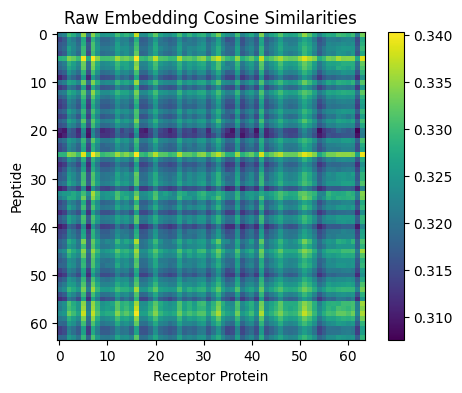

6353

In [12]:
curr_peptides, curr_receptors = next(iter(train_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap='viridis')
plt.colorbar()
plt.title("Raw Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np
gc.collect()

In [13]:
for epoch in range(num_epochs):
    train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()  # Clearing GPU cache after each epoch

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


OutOfMemoryError: ignored

In [ ]:
for epoch in range(num_epochs, 2*num_epochs):
    train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()  # Clearing GPU cache after each epoch

    print(f"Epoch {epoch + 1}/{2*num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
for epoch in range(2*num_epochs, 3*num_epochs):
    train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()  # Clearing GPU cache after each epoch

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# eval on test set
test_loss = evaluate(trained_model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
curr_peptides, curr_receptors = next(iter(train_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap='viridis')
plt.colorbar()
plt.title("Trained Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np
gc.collect()

In [ ]:
torch.save(trained_model.state_dict(), 'temp.pth')

In [ ]:
trained_model = ExtendedCLIP(320, 2, 2)
trained_model.load_state_dict(torch.load('temp.pth'))
trained_model.to(device)